In [20]:
import keras
import pandas as pd
from glob import glob
import os
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline


In [21]:
#Set path to the directory with pre-processed data
preprocess_path = "train_data_even_GAUSSIAN512"

train_files = glob(os.path.join(preprocess_path, "*.jpeg"))
df = pd.read_csv("allDataLabels.csv")

n_val_files = len(train_files) // 10

val_file_list = train_files[:n_val_files]
train_file_list = train_files[n_val_files:]

print(len(val_file_list))
print(len(train_file_list))

779
7017


In [22]:
def get_level(file, df):
    basename = os.path.basename(file)
    image_id = basename.split(".")[0]

    mini_df = df[df['image'] == image_id]
    if len(mini_df) < 1:
        return None

    return mini_df.values[0][1]

# Example: 1 -> [0, 1, 0, 0, 0]
def get_onehot(level):
    level_vec = np.zeros(5)
    level_vec[level] = 1
    
    return level_vec

### Image Augmentation

In [23]:
import imgaug as ia
from imgaug import augmenters as iaa

seq = iaa.Sequential(
    [
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Affine(
            scale=(0.9, 1.1),
            rotate=(-180, 180), # rotate by -180 to +180 degrees
        ),
    ],
    random_order=True
)

### Model

In [24]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def get_model(input_dim):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(input_dim, input_dim, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(96, (3, 3), activation='relu'))
    model.add(Conv2D(96, (3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(192, (3, 3), activation='relu'))
    model.add(Conv2D(192, (3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
     
    model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.003, momentum=0.9, nesterov=True), metrics=['accuracy'])

    return model

### Train

In [25]:
from keras.utils.data_utils import Sequence

class DataSequence_train(Sequence):
    def __init__(self, file_list, batch_size, augment=False):
        self.file_list = file_list
        self.batch_size = batch_size
        self.augment = augment    

    def __len__(self):
        return len(self.file_list) // self.batch_size

    def __getitem__(self, idx):
        imgs = []
        labels = []
        
        i = idx * self.batch_size
        
        while len(imgs) < self.batch_size:
            file = self.file_list[i]
            
            level = get_level(file, df)
            if level is None:
                print("missing level: " + file)
                i += 1
                continue
            
            img = cv2.imread(file)
            
            if img is not None:
                imgs.append(img)
                labels.append(get_onehot(level))               

            i += 1

        # Image augmentation
        if self.augment:
            imgs = seq.augment_images(imgs)

        return np.asarray(imgs).astype(np.float16), np.asarray(labels).astype(np.int8)

In [26]:
# ImageGenerator Testing
batch_size = 8
nb_epoch = 200

from datetime import datetime as dt
def get_model_id():
    time_str = dt.now().strftime('%Y-%m-%d-%H-%M-%S')
    exp_id = 'base_{}'.format(time_str)

    return exp_id

model_id = get_model_id()

model = get_model(512)

train_gen = DataSequence_train(train_file_list, batch_size, augment=True)
validate_gen = DataSequence_train(val_file_list, batch_size, augment=True)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint(model_id + "-val_loss_checkpoint.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=1e-6)
]

history = model.fit_generator(generator=train_gen, 
                              validation_data=validate_gen,
                              steps_per_epoch=len(train_gen),
                              validation_steps=len(validate_gen),
                              verbose=1,
                              epochs=nb_epoch,
                              callbacks=callbacks,
                             )


Epoch 1/200
877/877 [==============================] - 503s 573ms/step - loss: 1.6100 - acc: 0.2212 - val_loss: 1.6333 - val_acc: 0.2242

Epoch 00001: val_loss improved from inf to 1.63332, saving model to base_2018-07-04-15-11-40-val_loss_checkpoint.hdf5
Epoch 2/200
877/877 [==============================] - 479s 546ms/step - loss: 1.6053 - acc: 0.2360 - val_loss: 1.5803 - val_acc: 0.2513

Epoch 00002: val_loss improved from 1.63332 to 1.58032, saving model to base_2018-07-04-15-11-40-val_loss_checkpoint.hdf5
Epoch 3/200
877/877 [==============================] - 475s 542ms/step - loss: 1.5869 - acc: 0.2675 - val_loss: 1.5862 - val_acc: 0.2655

Epoch 00003: val_loss did not improve
Epoch 4/200
877/877 [==============================] - 474s 541ms/step - loss: 1.5823 - acc: 0.2654 - val_loss: 1.5639 - val_acc: 0.3170

Epoch 00004: val_loss improved from 1.58032 to 1.56390, saving model to base_2018-07-04-15-11-40-val_loss_checkpoint.hdf5
Epoch 5/200
877/877 [===========================

877/877 [==============================] - 472s 539ms/step - loss: 1.1602 - acc: 0.4839 - val_loss: 1.1223 - val_acc: 0.5258

Epoch 00040: val_loss did not improve
Epoch 41/200
877/877 [==============================] - 474s 540ms/step - loss: 1.1678 - acc: 0.4793 - val_loss: 1.1097 - val_acc: 0.4910

Epoch 00041: val_loss did not improve
Epoch 42/200
877/877 [==============================] - 469s 535ms/step - loss: 1.1601 - acc: 0.4826 - val_loss: 1.0575 - val_acc: 0.5335

Epoch 00042: val_loss improved from 1.08148 to 1.05750, saving model to base_2018-07-04-15-11-40-val_loss_checkpoint.hdf5
Epoch 43/200
877/877 [==============================] - 472s 538ms/step - loss: 1.1546 - acc: 0.5000 - val_loss: 1.1049 - val_acc: 0.5271

Epoch 00043: val_loss did not improve
Epoch 44/200
877/877 [==============================] - 478s 545ms/step - loss: 1.1533 - acc: 0.4907 - val_loss: 1.0676 - val_acc: 0.5245

Epoch 00044: val_loss did not improve
Epoch 45/200
877/877 [======================


Epoch 00080: val_loss did not improve
Epoch 81/200
877/877 [==============================] - 469s 535ms/step - loss: 0.9960 - acc: 0.5677 - val_loss: 0.9770 - val_acc: 0.5863

Epoch 00081: val_loss did not improve
Epoch 82/200
877/877 [==============================] - 471s 537ms/step - loss: 0.9928 - acc: 0.5650 - val_loss: 1.0139 - val_acc: 0.5515

Epoch 00082: val_loss did not improve
Epoch 83/200
877/877 [==============================] - 472s 538ms/step - loss: 0.9929 - acc: 0.5701 - val_loss: 0.9579 - val_acc: 0.5851

Epoch 00083: val_loss did not improve
Epoch 84/200
877/877 [==============================] - 470s 536ms/step - loss: 0.9884 - acc: 0.5647 - val_loss: 1.0668 - val_acc: 0.5245

Epoch 00084: val_loss did not improve

Epoch 00084: ReduceLROnPlateau reducing learning rate to 9.375000081490725e-05.
Epoch 85/200
877/877 [==============================] - 470s 536ms/step - loss: 0.9776 - acc: 0.5822 - val_loss: 0.9822 - val_acc: 0.5799

Epoch 00085: val_loss did not imp

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 510, 510, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 508, 508, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 254, 254, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 252, 252, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 250, 250, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 125, 125, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 123, 123, 96)      55392     
__________

In [28]:
model.save(model_id + "_Final_model.hdf5")

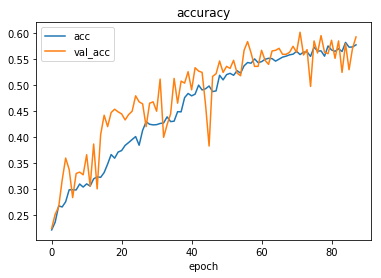

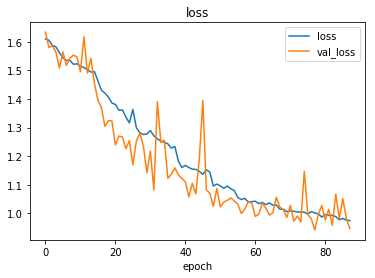

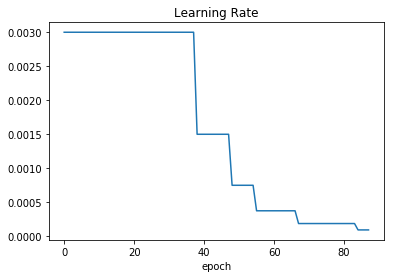

In [29]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

plt.plot(history.history['lr'])
plt.title('Learning Rate')
plt.xlabel('epoch')
plt.show()

### Test

In [30]:
from keras.utils.data_utils import Sequence

class DataSequence_test(Sequence):
    def __init__(self, file_list, batch_size, true_labels, augment=False):
        self.file_list = file_list
        self.batch_size = batch_size
        self.augment = augment
        self.true_labels = true_labels

    def __len__(self):
        return len(self.file_list) // self.batch_size

    def __getitem__(self, idx):
        imgs = []
        labels = []
        
        i = idx * self.batch_size
        
        while len(imgs) < self.batch_size:
            file = self.file_list[i]
            
            level = get_level(file, df)
            if level is None:
                print("missing level: " + file)
                i += 1
                continue
            
            img = cv2.imread(file)
            
            if img is not None:
                imgs.append(img)
                labels.append(get_onehot(level))
                true_labels.append(int(level))   
                true_imgs.append(img)

            i += 1

        # Image augmentation
        if self.augment:
            imgs = seq.augment_images(imgs)

        return np.asarray(imgs).astype(np.float16), np.asarray(labels).astype(np.int8)

In [31]:
# Test trained model with test set
batch_size = 8
test_preprocess_path = "test_origin_ratio_4K_GAUSSIAN512"
test_files = glob(os.path.join(test_preprocess_path, "*.jpeg"))
df = pd.read_csv("TestLabels.csv")
true_labels = []
true_imgs = []
test_gen = DataSequence_test(test_files, batch_size, true_labels, augment=False)
num_batches = (int)(len(test_files)/batch_size)
for index in range(0, num_batches):
    test_gen[index]
print(len(test_gen.true_labels))
print(len(true_imgs))
count = Counter(test_gen.true_labels)
print (count)

3536
3536
Counter({0: 2598, 2: 536, 1: 268, 4: 72, 3: 62})


In [32]:
labels_np = np.asarray(test_gen.true_labels)
imgs_np = np.array(true_imgs)
print(imgs_np.shape)
print(labels_np.shape)

(3536, 512, 512, 3)
(3536,)


In [33]:
# from keras.models import load_model
# model = load_model("base_2018-04-25-22-58-40_Final_model_2nd.hdf5")

y_pred = model.predict_generator(test_gen, len(test_gen))
y_pred = np.argmax(y_pred, axis=1)

In [34]:
score = model.evaluate_generator(test_gen, len(test_gen))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8814209131903239
Test accuracy: 0.6894796380090498


### Final Accuracy

In [39]:
print(float(str(score[1]*100)[:5]), "%", )

68.94 %


### Make Confusion Matrix

Normalized confusion matrix
[[0.82 0.11 0.04 0.   0.02]
 [0.49 0.36 0.13 0.   0.02]
 [0.23 0.25 0.27 0.18 0.07]
 [0.   0.02 0.11 0.69 0.18]
 [0.06 0.01 0.07 0.39 0.47]]


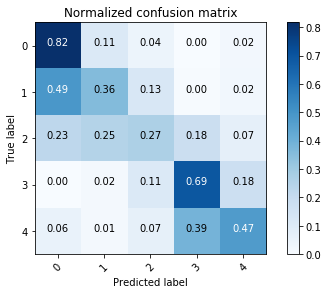

In [36]:
import itertools
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(labels_np, y_pred)
np.set_printoptions(precision=2)

class_names = [0,1,2,3,4]
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()